<a href="https://colab.research.google.com/github/divyanshuraj6815/END-NLP/blob/main/Experiment%2022/Semi_Supervised_NLI_(Small)_Training_(Siamese).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for Experiment

In [1]:
#!pip install datasets transformers sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp /content/drive/MyDrive/courses/Topics\ NLP/Project\ 2/* .

cp: -r not specified; omitting directory '/content/drive/MyDrive/courses/Topics NLP/Project 2/fine-tuned-roberta'


In [4]:
!unzip drive-download-20220905T204705Z-001.zip

Archive:  drive-download-20220905T204705Z-001.zip
replace snli_test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm.auto import tqdm

In [6]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

In [7]:
import torch

In [8]:
import math
import torch
import random
import time
import numpy as np
import collections
import pandas as pd
from tqdm.auto import tqdm

import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from transformers import AutoModelForCausalLM, AutoModelForMaskedLM
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
from datasets import Features, ClassLabel, Value

In [9]:
model_save_path = 'models/fine-tuned-roberta'
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}

# Fine Tune RoBERTa with a Siamese network
- https://sbert.net/docs/usage/semantic_textual_similarity.html


## Load model and data
- https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/sts/training_stsbenchmark.py

In [10]:
#You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
model_name = 'roberta-base'

# Read the dataset
num_epochs = 4
model_save_path = 'models/fine-tuned-roberta'

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
train_samples = []
dev_samples = []
test_samples = []
sen_emb = []

label2int = {"contradiction": -1, "entailment": 1, "neutral": 0}

reader = csv.DictReader(open('small_snli_train.tsv', 'r'), delimiter='\t', quoting=csv.QUOTE_NONE)
for row in reader:
  sen_emb.append ({'label': row['gold_label'], 'sentence1': row['sentence1'], 'sentence2': row['sentence2']})
  score = float(label2int[ row['gold_label'] ])  # Normalize score to range 0 ... 1
  inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
  train_samples.append(inp_example)
  inp_example = InputExample(texts=[row['sentence2'], row['sentence1']], label=score)
  train_samples.append(inp_example)

reader = csv.DictReader(open('snli_dev.tsv', 'r'), delimiter='\t', quoting=csv.QUOTE_NONE)
for row in reader:
  if row['gold_label'] not in label2int.keys ():
    continue
  score = float(label2int[ row['gold_label'] ])  # Normalize score to range 0 ... 1
  inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
  dev_samples.append(inp_example)

reader = csv.DictReader(open('snli_test.tsv', 'r'), delimiter='\t', quoting=csv.QUOTE_NONE)
for row in reader:
  if row['gold_label'] not in label2int.keys ():
    continue
  score = float(label2int[ row['gold_label'] ])  # Normalize score to range 0 ... 1
  inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)
  test_samples.append(inp_example)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [41]:
model = SentenceTransformer ('models/fine-tuned-roberta/')

Some weights of the model checkpoint at models/fine-tuned-roberta/ were not used when initializing RobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at models/fine-tuned-roberta/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [18]:
for element in tqdm(sen_emb):
  sentence = element['sentence1'] + ';' + element['sentence2']
  element['x1'] = model.encode ([sentence])[0]

  0%|          | 0/20000 [00:00<?, ?it/s]

## Fine Tune the Model and Evaluate

In [43]:
train_batch_size = 64
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='snli-dev')

In [47]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=1,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

In [21]:
!cp -r models/* /content/drive/MyDrive/courses/Topics\ NLP/Project\ 2/

In [22]:
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='snli-test')
test_evaluator(model, output_path=model_save_path)

0.53337338374914

## PCA and TSNE Graph before and after fine tuning RoBERTa
- https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [23]:
model.to (device)
for element in tqdm(sen_emb):
  sentence = element['sentence1'] + ';' + element['sentence2']
  element['x2'] = model.encode ([sentence])[0]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [48]:
model.to (device)
for element in tqdm(sen_emb):
  sentence = element['sentence1'] + ';' + element['sentence2']
  element['x3'] = model.encode ([sentence])[0]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [24]:
def pca_tsne_analysis (X, Y, x, y):
  feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
  df = pd.DataFrame(X,columns=feat_cols)
  df['y'] = y
  df['label'] = df['y'].apply(lambda i: str(i))
  X, y = None, None
  print('Size of the dataframe: {}'.format(df.shape))
  np.random.seed(42)
  rndperm = np.random.permutation(df.shape[0])
  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(df[feat_cols].values)
  df['pca-one'] = pca_result[:,0]
  df['pca-two'] = pca_result[:,1] 
  df['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df.loc[rndperm,:],
      legend="full",
      alpha=0.3
  )
  plt.show ()
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')
  ax.scatter(
      xs=df.loc[rndperm,:]["pca-one"], 
      ys=df.loc[rndperm,:]["pca-two"], 
      zs=df.loc[rndperm,:]["pca-three"], 
      c=df.loc[rndperm,:]["y"], 
      cmap='tab10'
  )
  ax.set_xlabel('pca-one')
  ax.set_ylabel('pca-two')
  ax.set_zlabel('pca-three')
  plt.show()

  df_subset = df.loc[rndperm[:],:].copy()
  data_subset = df_subset[feat_cols].values

  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(data_subset)
  df_subset['pca-one'] = pca_result[:,0]
  df_subset['pca-two'] = pca_result[:,1] 
  df_subset['pca-three'] = pca_result[:,2]
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(data_subset)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  df_subset['tsne-2d-one'] = tsne_results[:,0]
  df_subset['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(16,10))
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3
  )
  plt.show ()

  plt.figure(figsize=(16,7))
  ax1 = plt.subplot(1, 2, 1)
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3,
      ax=ax1
  )
  ax2 = plt.subplot(1, 2, 2)
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3,
      ax=ax2
  )
  plt.show ()

  pca_50 = PCA(n_components=50)
  pca_result_50 = pca_50.fit_transform(data_subset)
  print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

  time_start = time.time()
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
  tsne_pca_results = tsne.fit_transform(pca_result_50)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
  df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
  plt.figure(figsize=(16,4))
  ax1 = plt.subplot(1, 3, 1)
  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3,
      ax=ax1
  )
  ax2 = plt.subplot(1, 3, 2)
  sns.scatterplot(
      x="tsne-2d-one", y="tsne-2d-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3,
      ax=ax2
  )
  ax3 = plt.subplot(1, 3, 3)
  sns.scatterplot(
      x="tsne-pca50-one", y="tsne-pca50-two",
      hue="y",
      palette=sns.color_palette("hls", 3),
      data=df_subset,
      legend="full",
      alpha=0.3,
      ax=ax3
  )
  plt.show ()

  0%|          | 0/20000 [00:00<?, ?it/s]

Size of the dataframe: (20000, 770)
Explained variation per principal component: [0.22808455 0.03506784 0.03306244]


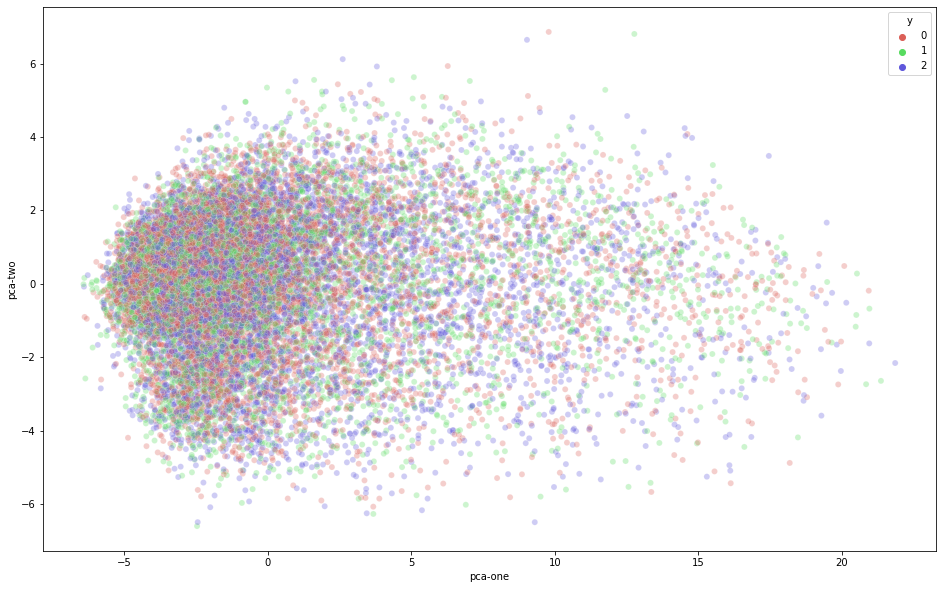

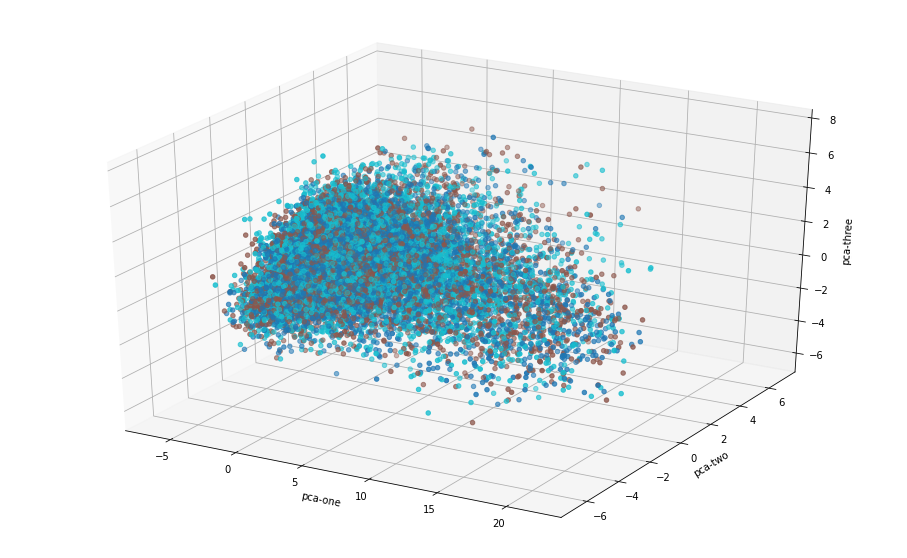

Explained variation per principal component: [0.22808416 0.03506778 0.03306236]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.018s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 18.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

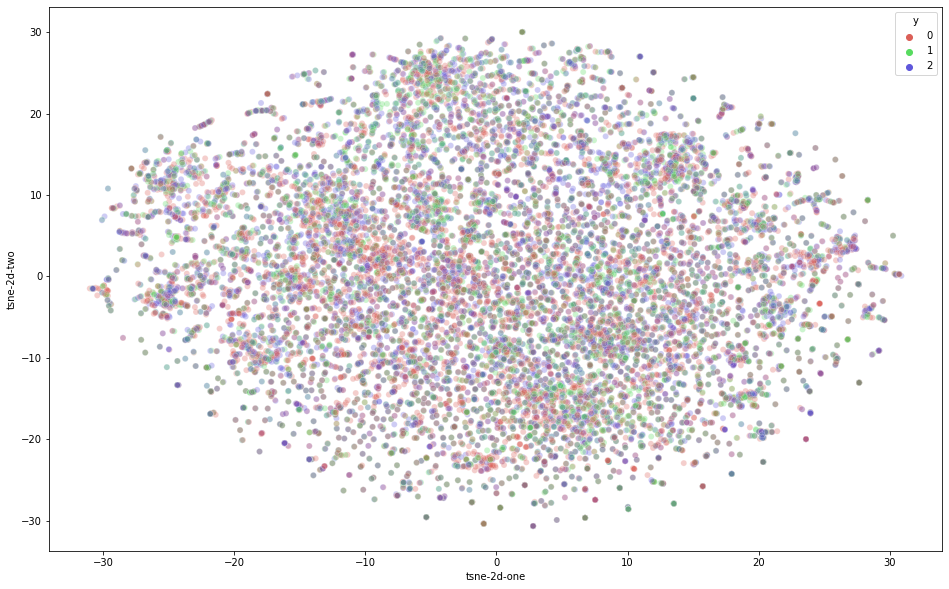

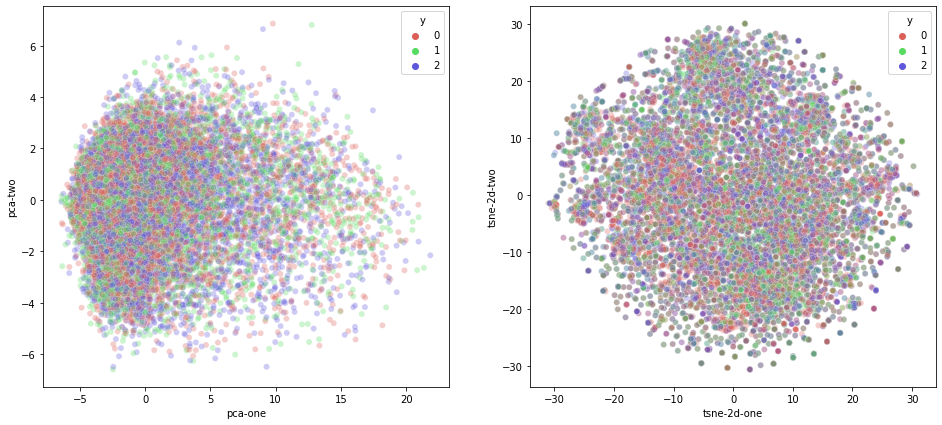

Cumulative explained variation for 50 principal components: 0.7409977316856384


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 64.5176362991333 seconds


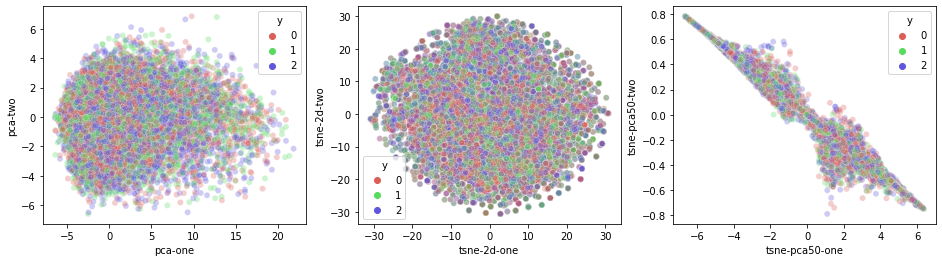

In [25]:
x = []
y = []
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}

for element in tqdm (sen_emb):
  x.append (element['x1'])
  y.append (label2int[ element['label'] ])

X = np.asarray (x)
Y = np.asarray (y)

pca_tsne_analysis (X, Y, x, y)

  0%|          | 0/20000 [00:00<?, ?it/s]

Size of the dataframe: (20000, 770)
Explained variation per principal component: [0.23783405 0.10393444 0.04143786]


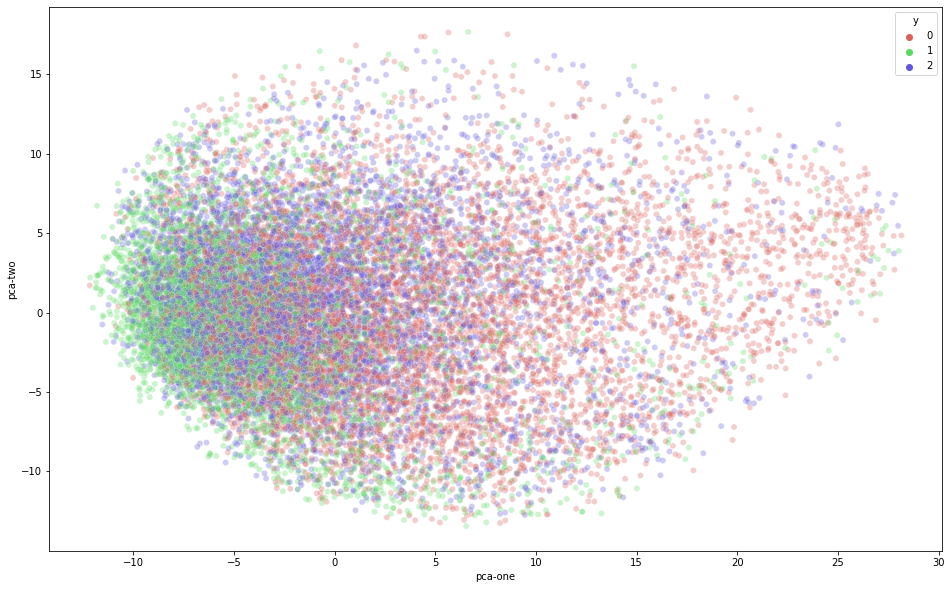

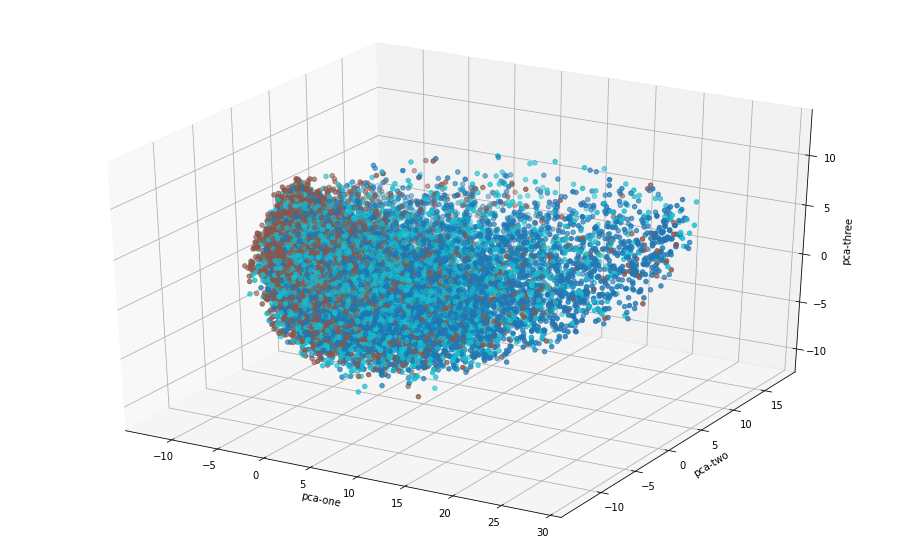

Explained variation per principal component: [0.23783378 0.10393432 0.04143779]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.017s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 18.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

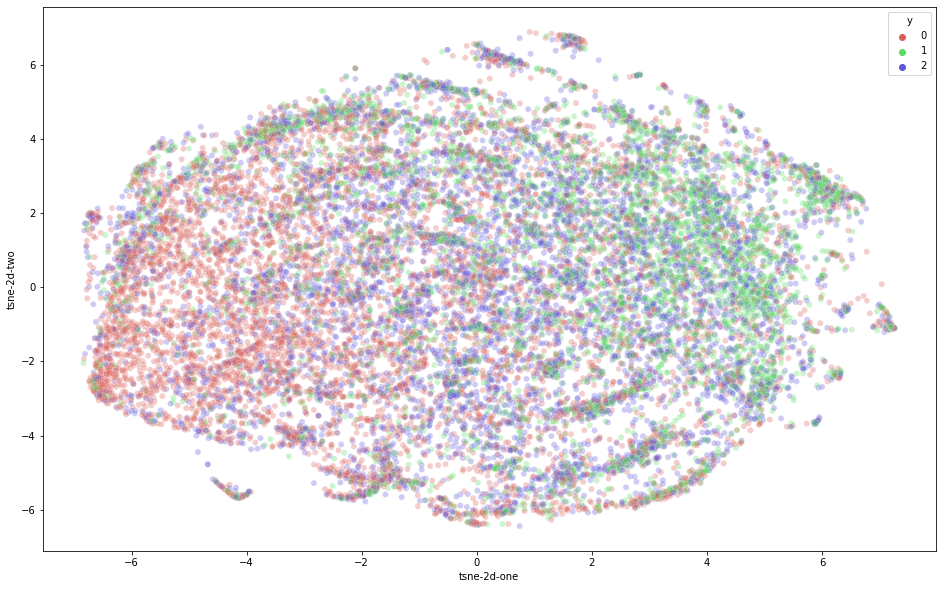

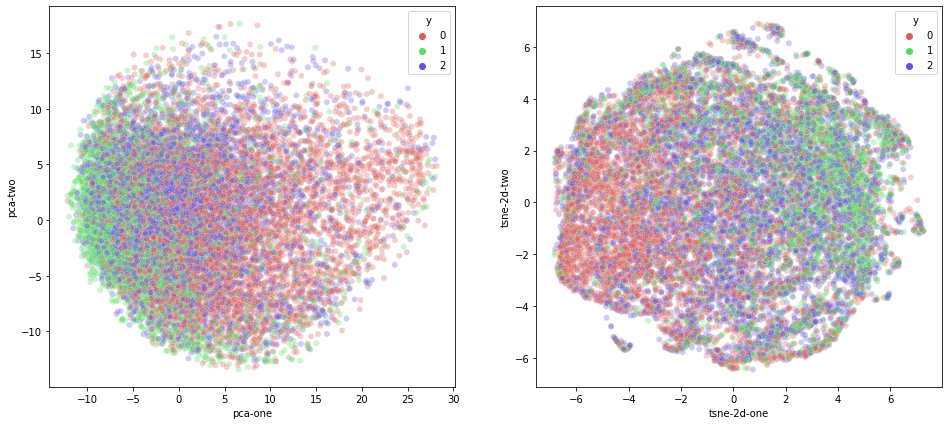

Cumulative explained variation for 50 principal components: 0.7967767715454102


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 86.46370244026184 seconds


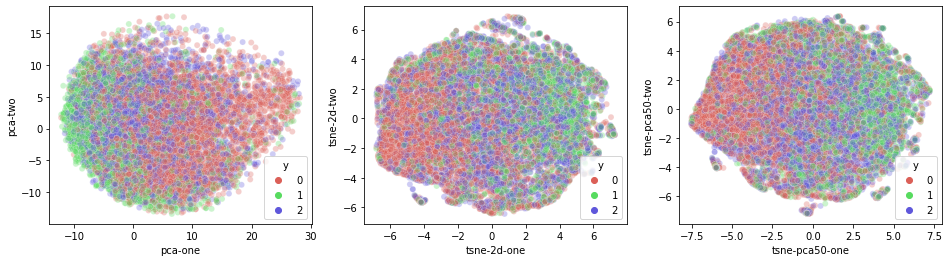

In [26]:
x = []
y = []
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}

for element in tqdm (sen_emb):
  x.append (element['x2'])
  y.append (label2int[ element['label'] ])

X = np.asarray (x)
Y = np.asarray (y)

pca_tsne_analysis (X, Y, x, y)

  0%|          | 0/20000 [00:00<?, ?it/s]

Size of the dataframe: (20000, 770)
Explained variation per principal component: [0.39080057 0.09976888 0.04460277]


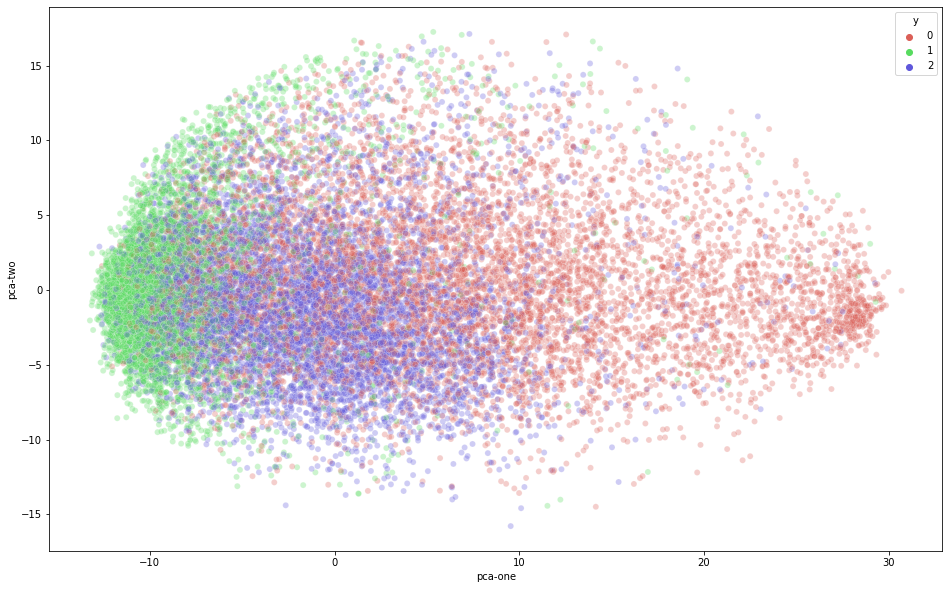

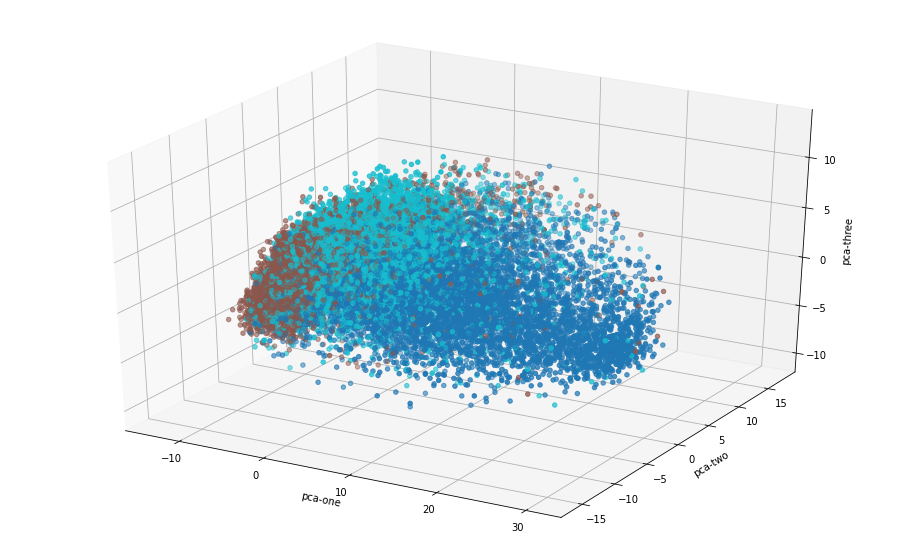

Explained variation per principal component: [0.39079982 0.09976864 0.04460271]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.019s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 20000 samples in 18.654s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sample 13000 / 20000
[t-SNE] Computed conditional probabilities for sample 14000 / 2000

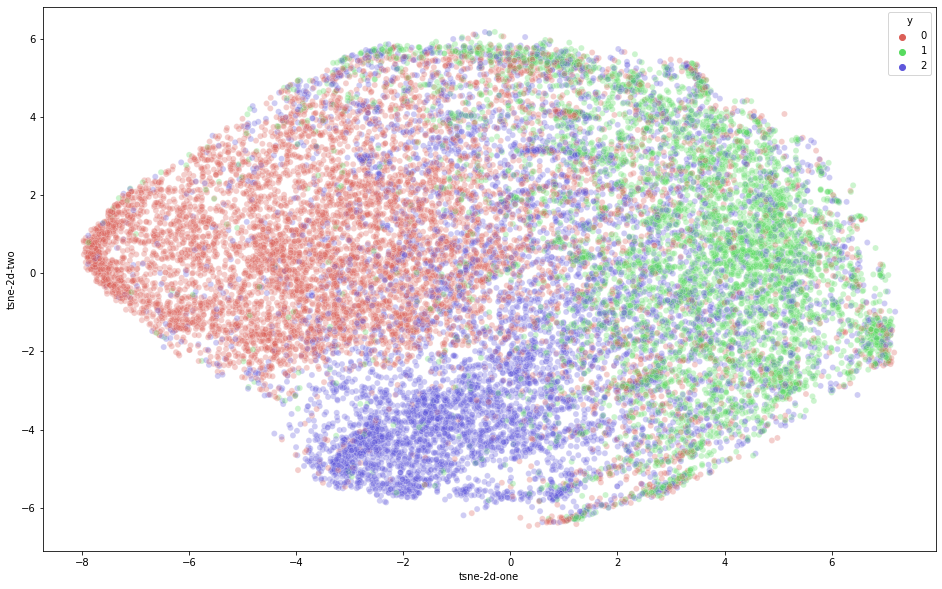

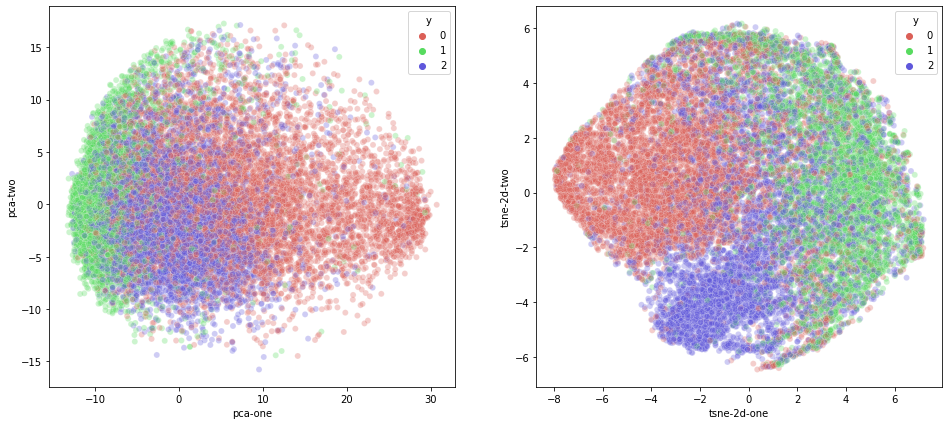

Cumulative explained variation for 50 principal components: 0.8599839806556702


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 96.99712371826172 seconds


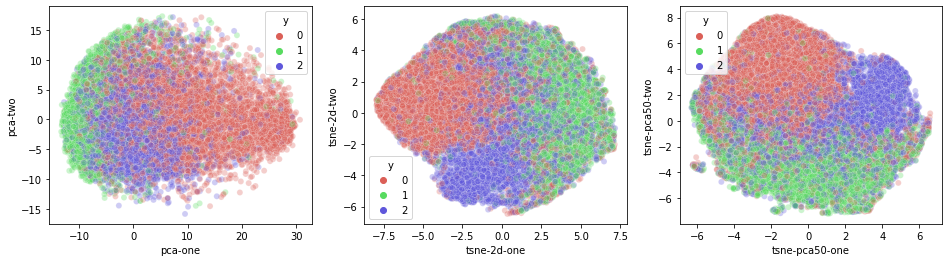

In [49]:
x = []
y = []
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}

for element in tqdm (sen_emb):
  x.append (element['x3'])
  y.append (label2int[ element['label'] ])

X = np.asarray (x)
Y = np.asarray (y)

pca_tsne_analysis (X, Y, x, y)

# NLI as Classification task

In [27]:
!cp -r /content/drive/MyDrive/courses/Topics\ NLP/Project\ 2/ models/*

## Functions for Load and Visualize datasets

In [28]:
def load_and_filter_dataset ():
  dataset = load_dataset('csv', 
                        data_files={
                            'train': ['small_snli_train.tsv'],
                            'test': ['snli_test.tsv'],
                            'validation': ['snli_dev.tsv']
                            }, 
                        delimiter = '\t')
  dataset = dataset.filter(lambda example: example['gold_label'] != '-')

  labels = ClassLabel(names = ['contradiction', 'entailment', 'neutral'])
  x = [label2int[element] for element in dataset['train']['gold_label']]
  dataset['train']=dataset['train'].add_column('label',x)
  x = [label2int[element] for element in dataset['test']['gold_label']]
  dataset['test']=dataset['test'].add_column('label',x)
  x = [label2int[element] for element in dataset['validation']['gold_label']]
  dataset['validation']=dataset['validation'].add_column('label',x)
  dataset = dataset.cast_column ('label', labels)
  dataset = dataset.rename_column ("sentence1", "premise")
  dataset = dataset.rename_column ("sentence2", "hypothesis")
  dataset = dataset.remove_columns (['gold_label', 'sentence1_binary_parse', 'sentence2_binary_parse', 'sentence1_parse', 'sentence2_parse', 'captionID', 'pairID', 'label1', 'label2', 'label3', 'label4', 'label5'])
  return dataset

In [29]:
def visualize_dataset (dataset: datasets.dataset_dict.DatasetDict) -> None:

  labels = dataset['train'].features['label'].names

  try:
    # Graph for split wise graph
    split_wise_labels = [key for key, value in dataset.items ()]
    split_wise_numbers = [value.num_rows for key, value in dataset.items ()]
    split_wise_explode = [random.randint (1, 5) / 10 if key != 'train' else 0 for key, value in dataset.items ()]

    sen_length = {}

    # Graph for total label wise split
    split_wise_label_wise = {}
    total_label_wise_split = [0] * len (labels)
    for key, value in dataset.items ():
      counter = collections.Counter (value['label'])
      temp = [0] * len (labels)
      for index, total in counter.items ():
        temp[ index ] += total
      split_wise_label_wise[key] = temp  
      total_label_wise_split = [x + y for x, y in zip(total_label_wise_split, temp)]

      sen_length[key] = {'premise': [], 'hypothesis': [], 'sum': []}
      
      for element in value:
        sen_length[key]['premise'].append ( len(element['premise'].split ()) )
        sen_length[key]['hypothesis'].append ( len(element['hypothesis'].split ()) )
        sen_length[key]['sum'].append (sen_length[key]['premise'][-1] + sen_length[key]['hypothesis'][-1])
      
    # Graph for split wise and label wise
    split_wise_label_wise = [split_wise_label_wise[label] for label in split_wise_labels]
    split_wise_label_wise = [[split_wise_label_wise[j][i] for j in range(len(split_wise_label_wise))] for i in range(len(split_wise_label_wise[0]))]

    fig, axs = plt.subplots(2,3, figsize=(20,10))
    fig.tight_layout()
    # Graph 1
    axs[0, 0].pie(x = split_wise_numbers, explode=split_wise_explode, labels=split_wise_labels, autopct='%1.1f%%', startangle=90)
    axs[0, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[0, 0].set_title ('Train, Test, Validation Split')

    # Graph 2
    axs[0, 1].pie(x = total_label_wise_split, labels=labels, autopct='%1.1f%%', startangle=90)
    axs[0, 1].axis('equal')
    axs[0, 1].set_title ('Label wise split for entire Dataset')

    # Graph 3
    X = np.arange(3)
    axs[0, 2].bar(X + 0.00, split_wise_label_wise[0], color = 'b', width = 0.25)
    axs[0, 2].bar(X + 0.25, split_wise_label_wise[1], color = 'g', width = 0.25)
    axs[0, 2].bar(X + 0.50, split_wise_label_wise[2], color = 'r', width = 0.25)
    axs[0, 2].legend(labels=labels)
    axs[0, 2].set_xticklabels(["", split_wise_labels[0], "", split_wise_labels[1], "", split_wise_labels[2]]) 
    axs[0, 2].set_title ('Split Wise, Label Wise Data')

    axs[1, 0].hist(sen_length['train']['premise'], bins=50, label="premise length in train set", alpha=0.5)
    axs[1, 0].hist(sen_length['validation']['premise'], bins=50, label="premise length in validation set", alpha=0.5)
    axs[1, 0].legend(loc='best')
    axs[1, 0].set_title ('Premise Length Comparison')
    axs[1, 0].set_xlabel('Sentence Length')
    axs[1, 0].set_ylabel('Frequency')
    
    axs[1, 1].hist(sen_length['train']['hypothesis'], bins=50, label="hypothesis length in train set", alpha=0.5)
    axs[1, 1].hist(sen_length['validation']['hypothesis'], bins=50, label="hypothesis length in validation set", alpha=0.5)
    axs[1, 1].legend(loc='best')
    axs[1, 1].set_title ('Hypothesis Length Comparison')
    axs[1, 1].set_xlabel('Sentence Length')
    axs[1, 1].set_ylabel('Frequency')

    axs[1, 2].hist(sen_length['train']['sum'], bins=50, label="Input length in train set", alpha=0.5)
    axs[1, 2].hist(sen_length['validation']['sum'], bins=50, label="Input length in validation set", alpha=0.5)
    axs[1, 2].legend(loc='best')
    axs[1, 2].set_title ('Input Length Comparison')
    axs[1, 2].set_xlabel('Sentence Length')
    axs[1, 2].set_ylabel('Frequency')

    plt.show()

  except Exception as e:
    print ("Cannot plot the graphs: ", str (e))

## Model Load and Train Loop Functions

In [30]:
def tokenize_dataset (dataset, model_checkpoint = 'roberta-base'):
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  
  def tokenize_function (examples):
    return tokenizer (examples['premise'], 
                      examples['hypothesis'],
                      add_special_tokens = True,
                      max_length=64, 
                      padding = 'max_length', 
                      truncation = True)
    
  tokenized_datasets = dataset.map (tokenize_function,
                                  batched = True,
                                  remove_columns = ['premise', 'hypothesis']
                                  ).with_format("torch")
  return (tokenizer, tokenized_datasets)

def classification_model (dataset, model_checkpoint = 'roberta-base'):

  classes = dataset['train'].features['label'].names
  id2label = {i: element for i, element in enumerate (classes)}
  label2id = {element: i for i, element in enumerate (classes)}

  model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels = len (classes), 
                                                             id2label = id2label, 
                                                             label2id = label2id)
  return model

In [31]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat), pred_flat, labels_flat

def train (model, optimizer, scheduler, data_loader, epoch, eval = False):

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    stage = 'Eval' if eval else 'Train'
    total_loss = 0
    total_accuracy = 0
    total = 0
    true_labels = []
    predictions = []

    if eval == True:
      model.eval ()
    else:
      model.train()

    pbar = tqdm(data_loader)
    for batch in pbar:

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)

        if eval:
          with torch.no_grad():        
            result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        else:
          model.zero_grad()        
          result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
          
        loss = result.loss
        logits = result.logits
        total_loss += loss.item()

        if eval == False:
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()

          scheduler.step()
            
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        (acc, pred, lbls) = flat_accuracy(logits, label_ids)
        total_accuracy += acc
        predictions += list(pred)
        true_labels += list(lbls)
        total += len (label_ids)
        pbar.set_description(f"[{stage}] Epoch: {epoch:3}, Total: {total:6}, Accuracy : {(total_accuracy / total):.4f}, Loss: {loss:.4f}")
    pbar.close ()
    return [total, total_accuracy, total_loss, predictions, true_labels]

In [32]:
def model_training (model, epochs, tokenized_datasets, batch_size):
  
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to (device)

  train_loader = DataLoader (tokenized_datasets['train'],
                           sampler = RandomSampler(tokenized_datasets['train']),
                           batch_size = batch_size)
  val_loader = DataLoader (tokenized_datasets['validation'],
                          sampler = SequentialSampler(tokenized_datasets['validation']),
                          batch_size = batch_size)
  test_loader = DataLoader (tokenized_datasets['test'],
                          sampler = SequentialSampler(tokenized_datasets['test']),
                          batch_size = batch_size)

  optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  total_steps = len(train_loader) * epochs

  # Create the learning rate scheduler.
  #scheduler = get_linear_schedule_with_warmup(optimizer, 
  #                                          num_warmup_steps = 0, # Default value in run_glue.py
  #                                          num_training_steps = total_steps)
  scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 50, # Default value in run_glue.py
                                            num_training_steps = total_steps,
                                            num_cycles = 2)
  
  seed_val = 42
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = {'epoch': [], 'train_loss': [], 'eval_loss': [], 'train_acc': [], 'eval_acc': []}

  for epoch_i in tqdm(range(0, epochs)):

      [total_train, total_train_accuracy, total_train_loss, predictions, true_labels] = train (model, optimizer, scheduler, train_loader, epoch_i, eval = False)
      [total_eval, total_eval_accuracy, total_eval_loss, predictions, true_labels] = train (model, optimizer, scheduler, val_loader, epoch_i, eval = True)

      # Record all statistics from this epoch.
      training_stats['epoch'].append (epoch_i + 1)
      training_stats['train_loss'].append (total_train_loss / len (train_loader))
      training_stats['eval_loss'].append (total_eval_loss / len (val_loader))
      training_stats['train_acc'].append (total_train_accuracy / total_train)
      training_stats['eval_acc'].append (total_eval_accuracy / total_eval)

  test_metrics = {}    
  [test_metrics['total'], test_metrics['accuracy'], test_metrics['loss'], test_metrics['predictions'], test_metrics['true_labels']] = train (model, optimizer, scheduler, test_loader, 0, eval = True)

  fig, axs = plt.subplots(1,2, figsize=(15,5))
  fig.tight_layout()
  # Graph for Loss
  axs[0].plot(training_stats['epoch'], training_stats['train_loss'], 'g', label='Training loss')
  axs[0].plot(training_stats['epoch'], training_stats['eval_loss'], 'b', label='Validation loss')
  axs[0].set_title ('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  axs[0].legend ()

  # Graph for Accuracy
  axs[1].plot(training_stats['epoch'], training_stats['train_acc'], 'g', label='Training accuracy')
  axs[1].plot(training_stats['epoch'], training_stats['eval_acc'], 'b', label='Validation accuracy')
  axs[1].set_title ('Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend ()

  plt.show ()
  return (model, test_metrics)

## Load Data and Train

  0%|          | 0/3 [00:00<?, ?it/s]

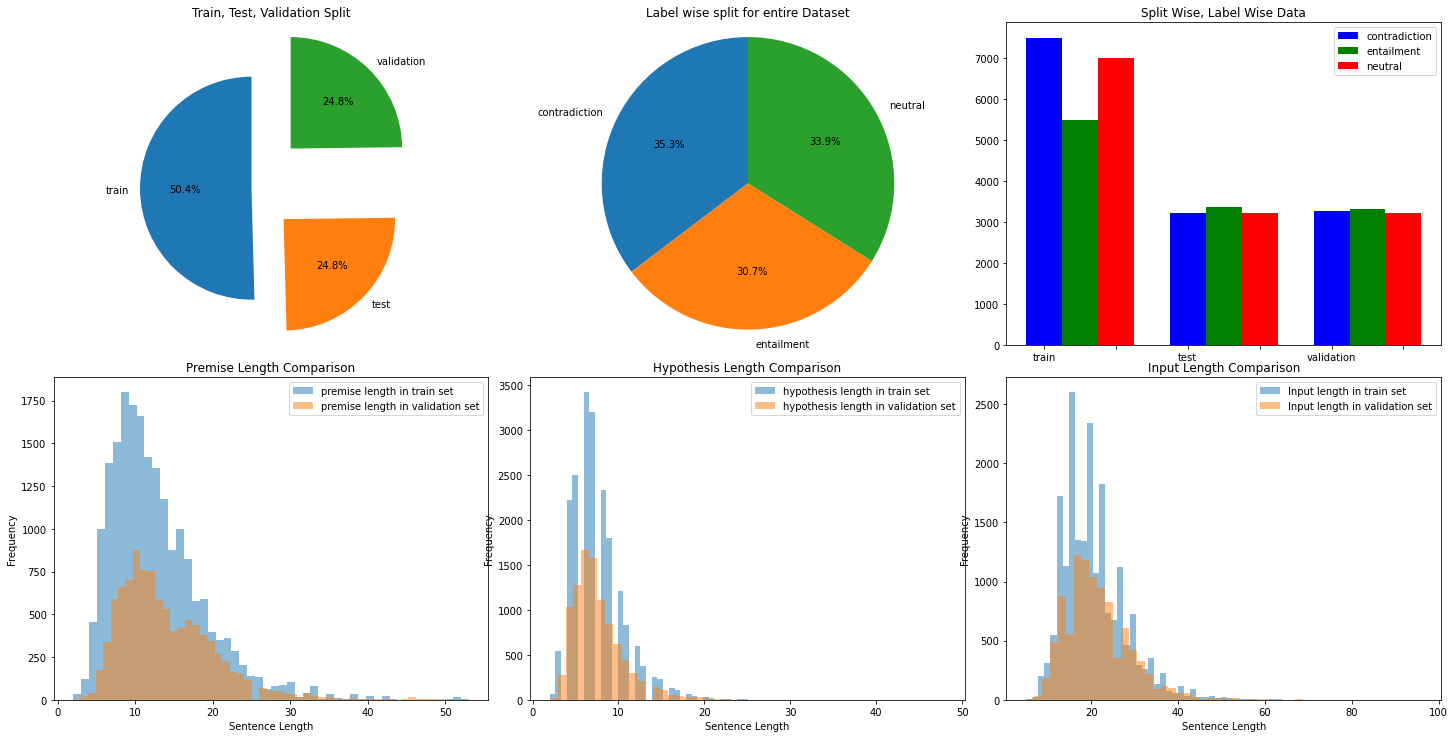

In [33]:
dataset = load_and_filter_dataset ()
visualize_dataset (dataset)

In [34]:
(tokenizer, tokenized_dataset) = tokenize_dataset (dataset, model_checkpoint = model_save_path)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [35]:
model = classification_model (dataset, model_checkpoint = model_save_path)

Some weights of the model checkpoint at models/fine-tuned-roberta were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at models/fine-tuned-roberta and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to

In [36]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

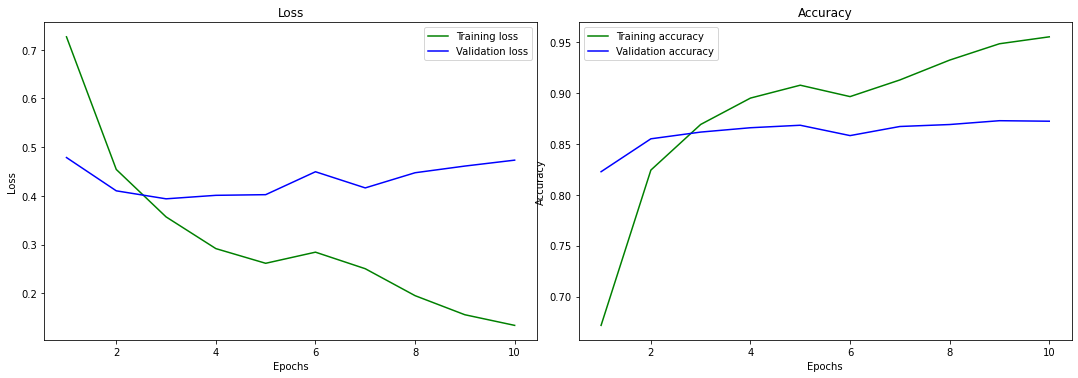

In [37]:
'''
lr = 2e-5
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 50, # Default value in run_glue.py
                                            num_training_steps = total_steps,
                                            num_cycles = 2)
'''
(model, test_metrics) = model_training (model, 10, tokenized_dataset, 128)

In [38]:
model.eval ()
model.save_pretrained (model_save_path)

In [39]:
!cp -r models/* /content/drive/MyDrive/courses/Topics\ NLP/Project\ 2/

In [52]:
from sklearn.metrics import classification_report
x = classification_report(test_metrics['true_labels'], test_metrics['predictions'], digits=3, output_dict=True)

In [53]:
import json
json.dumps (x)

'{"0": {"precision": 0.8819402074435632, "recall": 0.893110905159098, "f1-score": 0.8874904067536454, "support": 3237}, "1": {"precision": 0.896793893129771, "recall": 0.8720308788598575, "f1-score": 0.8842390486226102, "support": 3368}, "2": {"precision": 0.8141241210638949, "recall": 0.8272755514134824, "f1-score": 0.8206471494607088, "support": 3219}, "accuracy": 0.8643118892508144, "macro avg": {"precision": 0.8642860738790764, "recall": 0.8641391118108125, "f1-score": 0.8641255349456548, "support": 9824}, "weighted avg": {"precision": 0.8648114647048617, "recall": 0.8643118892508144, "f1-score": 0.8644734055920728, "support": 9824}}'

# Inference

In [ ]:
from transformers import pipeline

text_classifier = pipeline (
    'text-classification',
    tokenizer = model_save_path,
    model = model_save_path
)